In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']


import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
# For time stamps
from datetime import datetime

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,Conv1D,Flatten,MaxPooling1D,LSTM
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

In [2]:
# 0002 中電
# 0003 煤氣
# 0012 恒基1981 
# 0017 新世界1972
# 1398 工商2006
# 3988 中國銀行 2006
# 0669 創科實業
# 2382 舜宇光學06/2007
# 1299 友邦2010
# 0388 港交所 2000

# Set up End and Start times for data grab
tech_list = ['0002.HK', '0003.HK', '0012.HK', '0017.HK','1398.HK','3988.HK','0669.HK','2382.HK','1299.HK','0388.HK']
# company_name = ['中電', '煤氣', '恒基', '新世界','工商','中國銀行','創科實業','友邦','港交所']
dfs = {}  # 使用字典存储每个股票的数据

for stock in tech_list:
    data = yf.download(stock, "2011-01-01", "2018-12-31")
    dfs[stock] = data
    

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


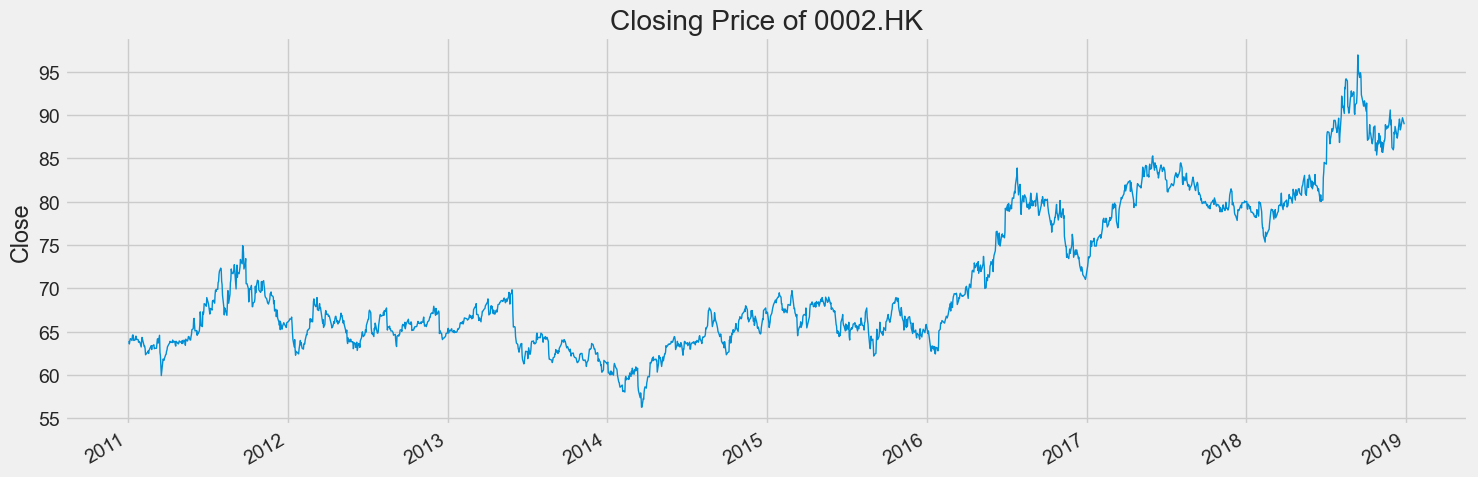

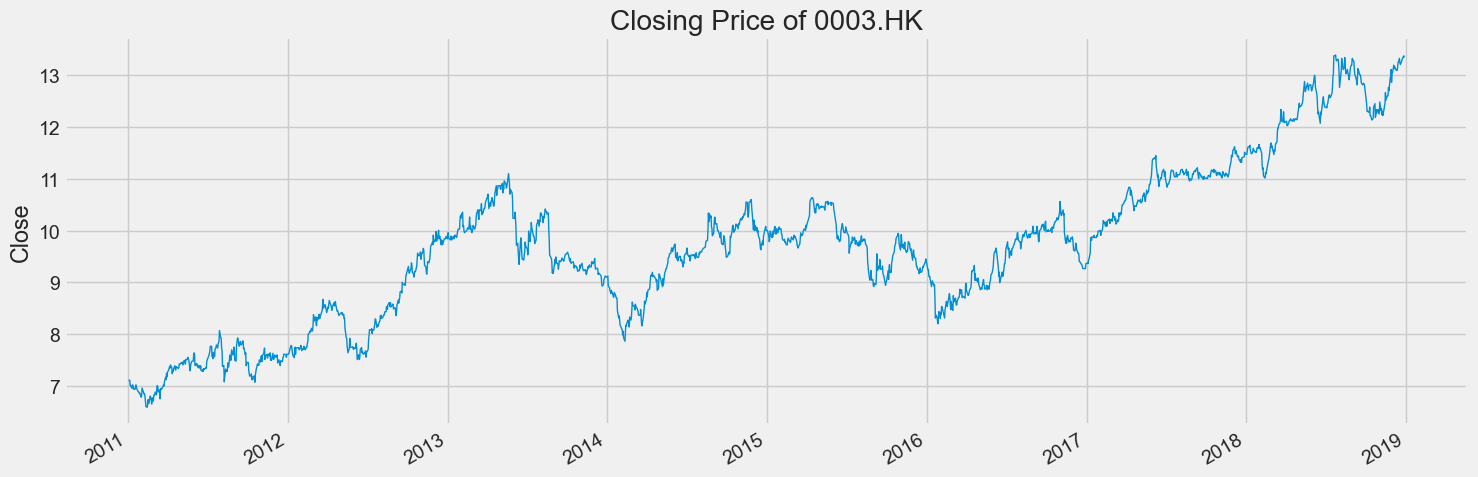

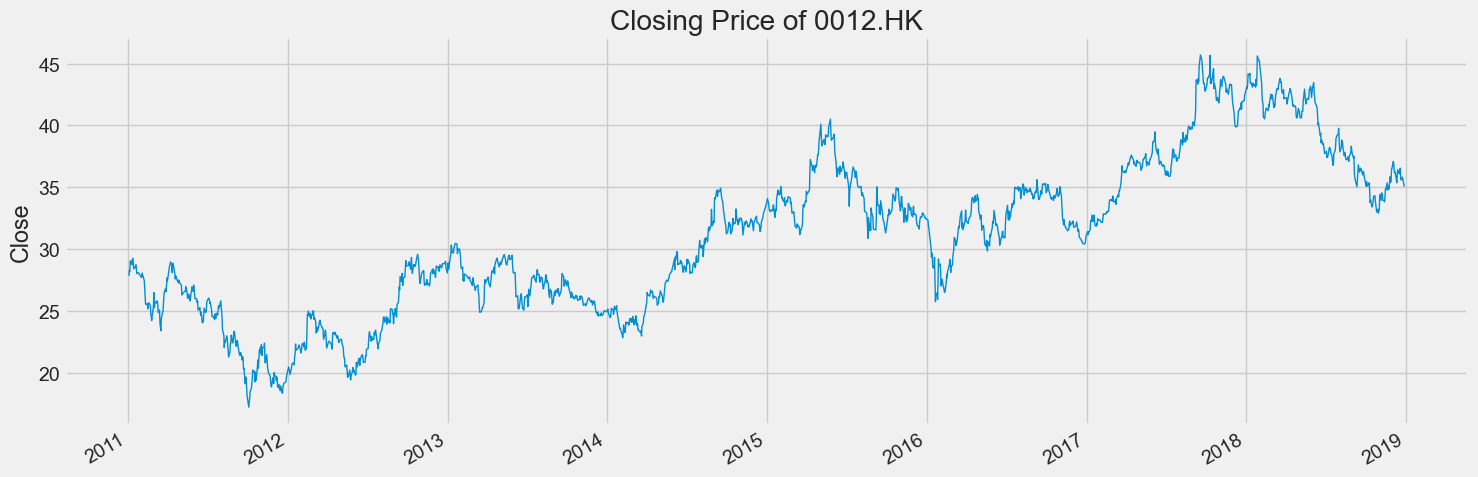

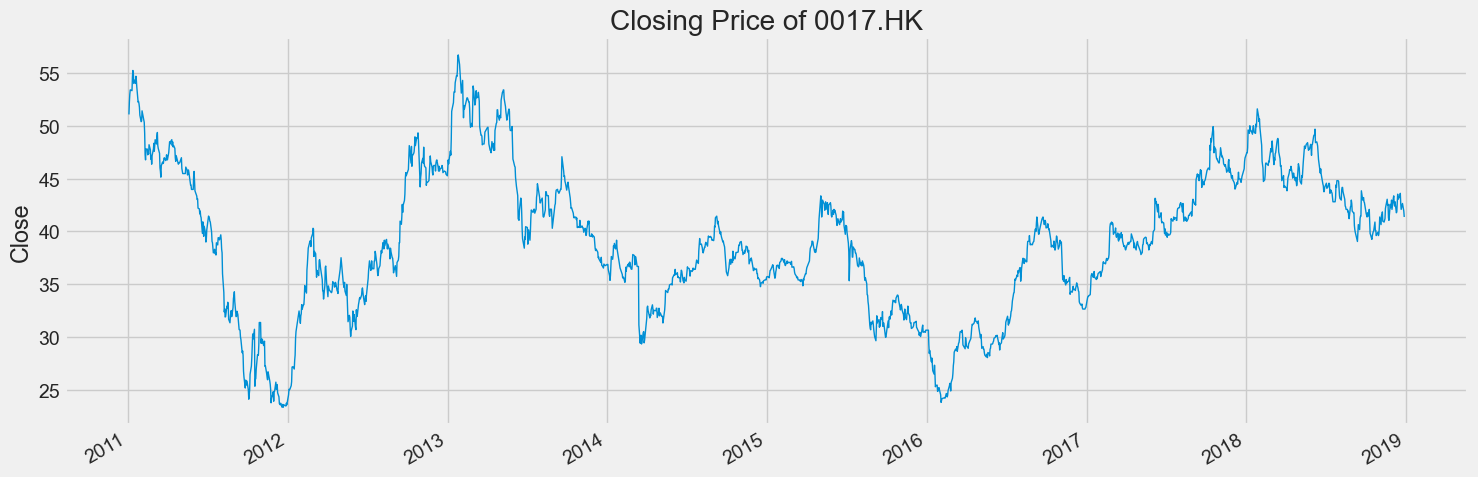

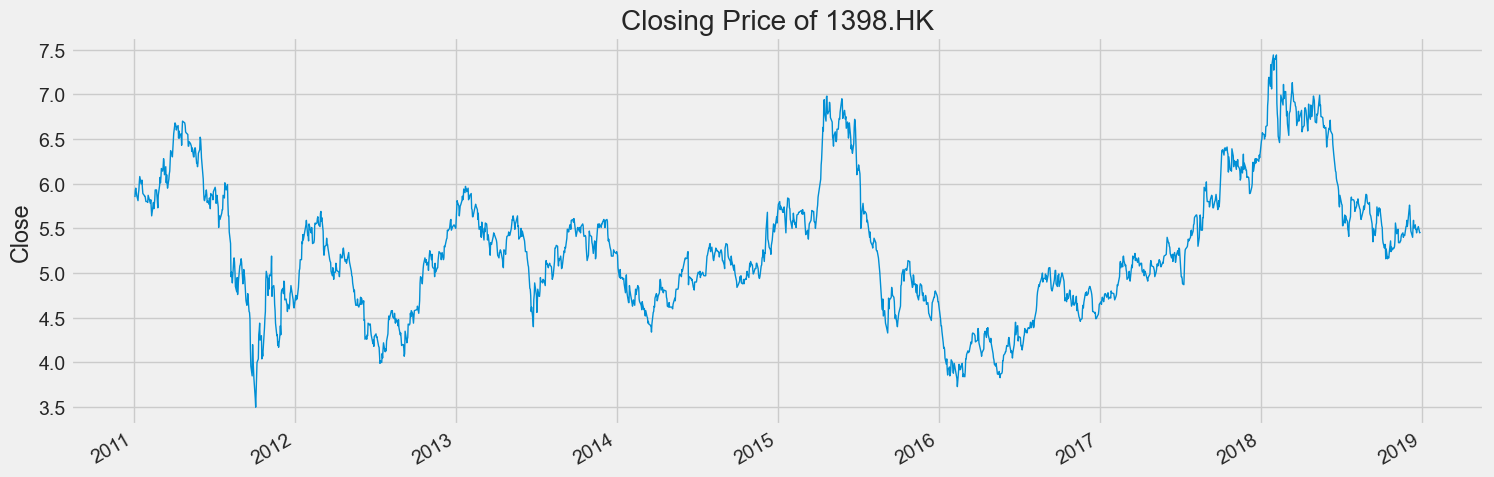

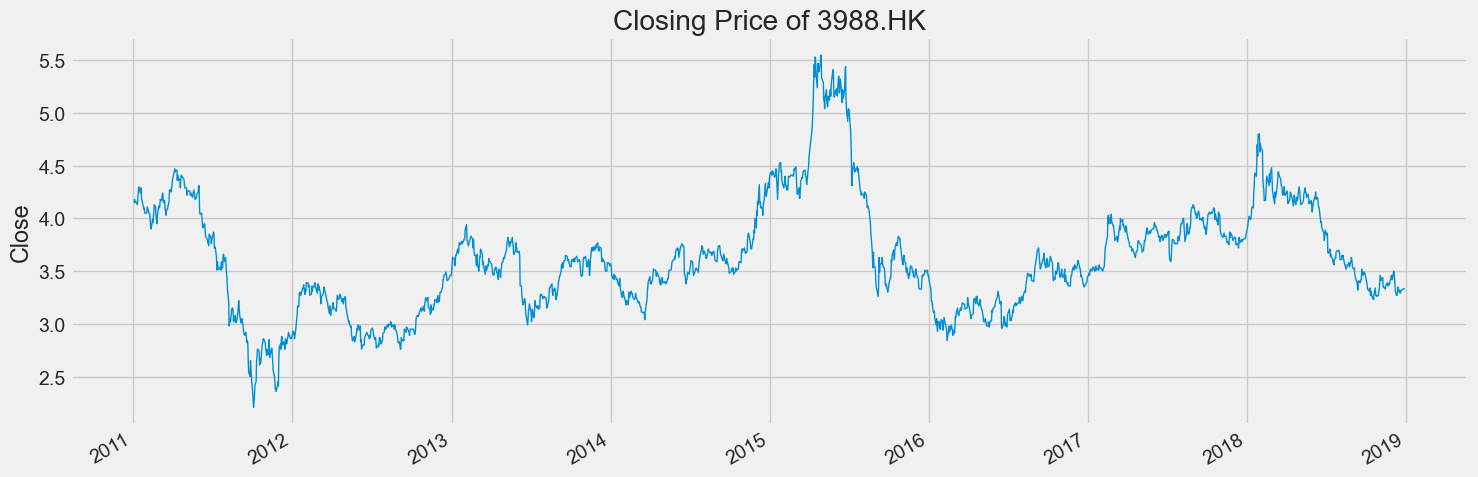

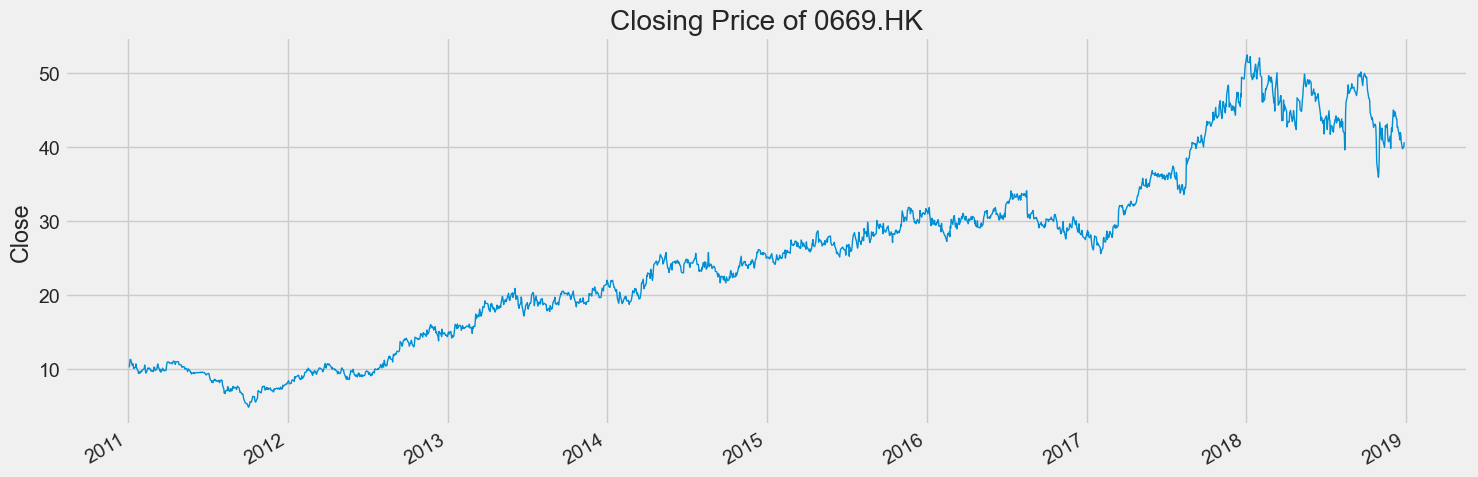

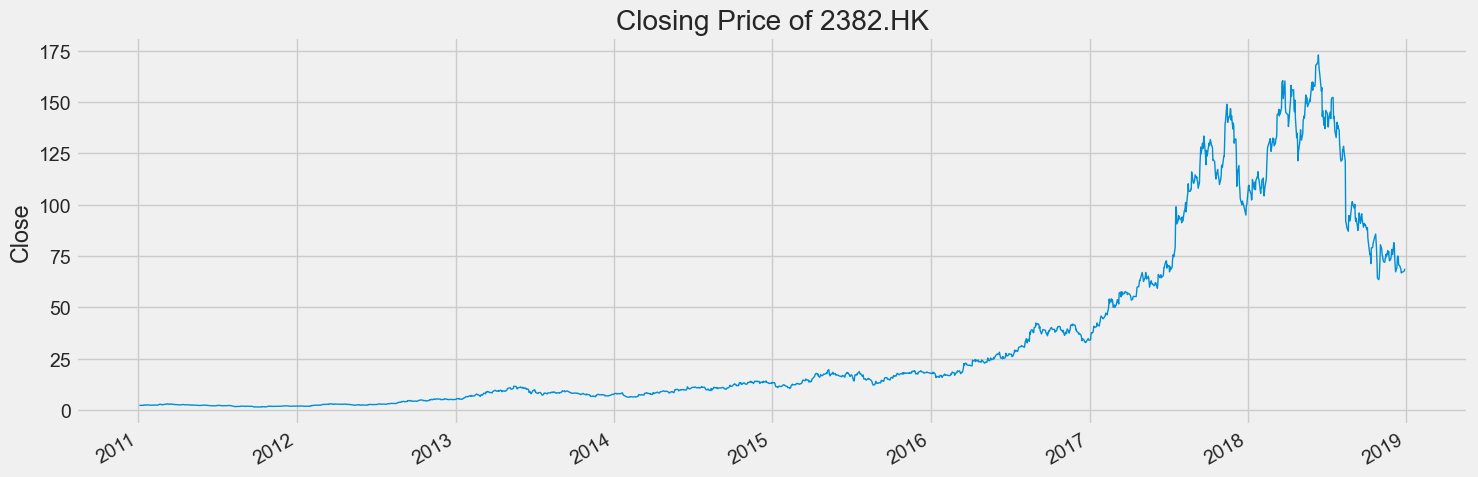

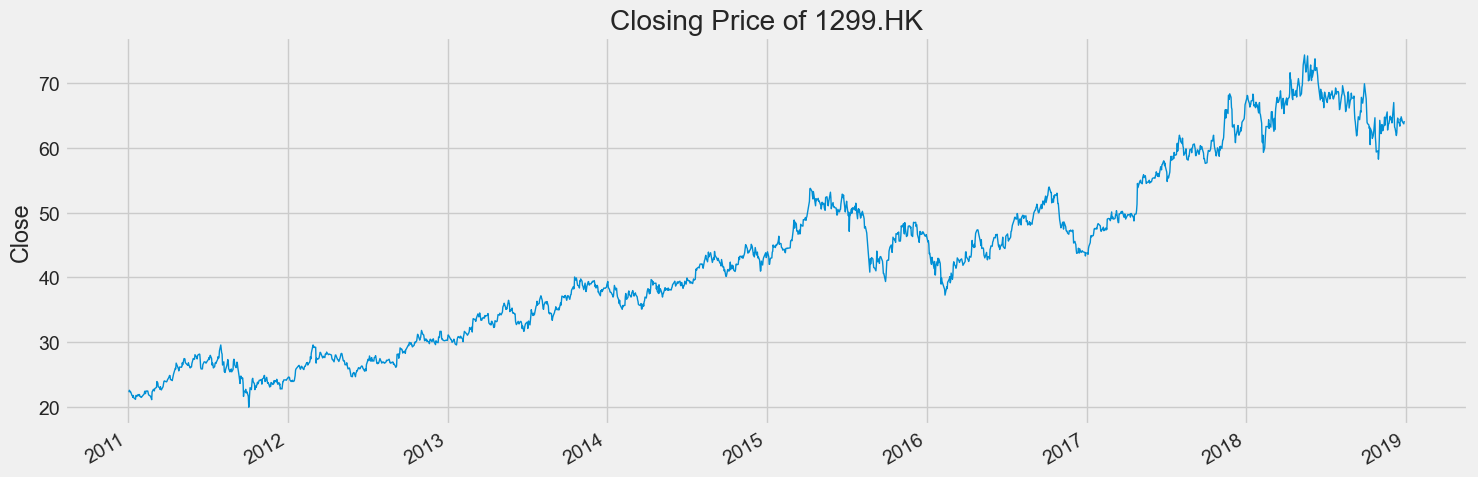

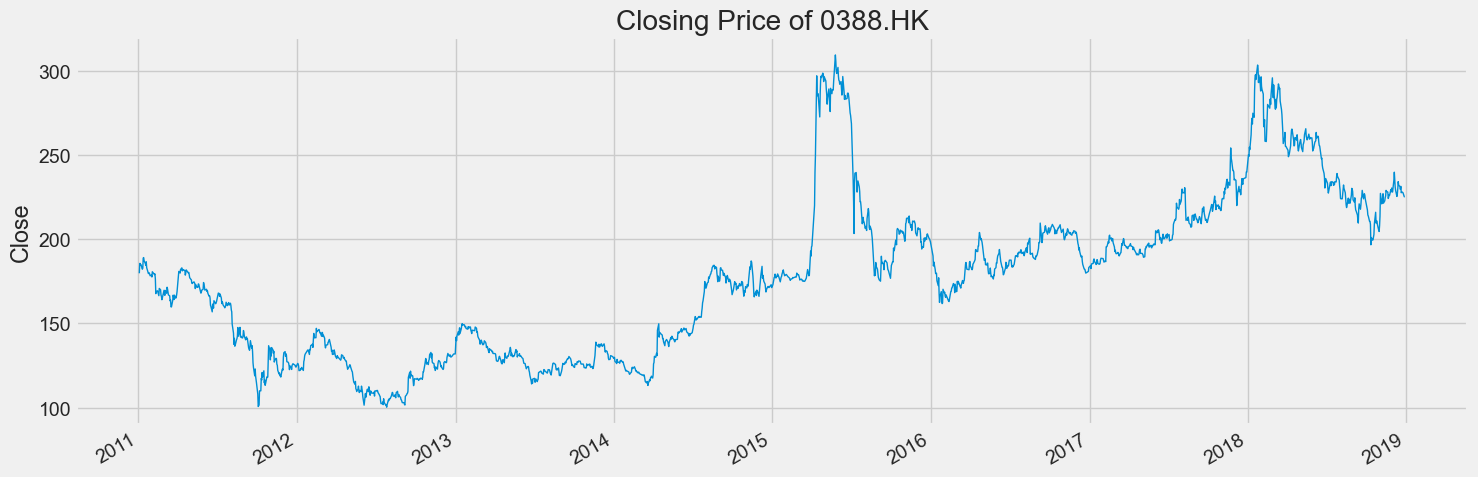

In [3]:
# Let's see a historical view of the closing price
for i, stock in enumerate(tech_list, 1):
    df = dfs[stock]
    plt.figure(figsize=(15,5))
    df['Close'].plot(linewidth=1)
    plt.ylabel('Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {tech_list[i - 1]}")
    plt.tight_layout()

In [4]:
# Let's see a historical view of the closing price
for stock in tech_list:
    df = dfs[stock]
    df['Daily Return'] = df['Close'].pct_change()


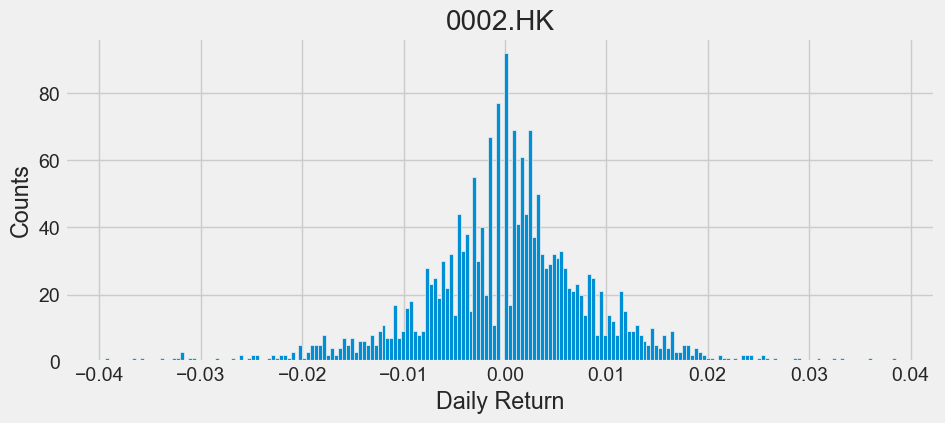

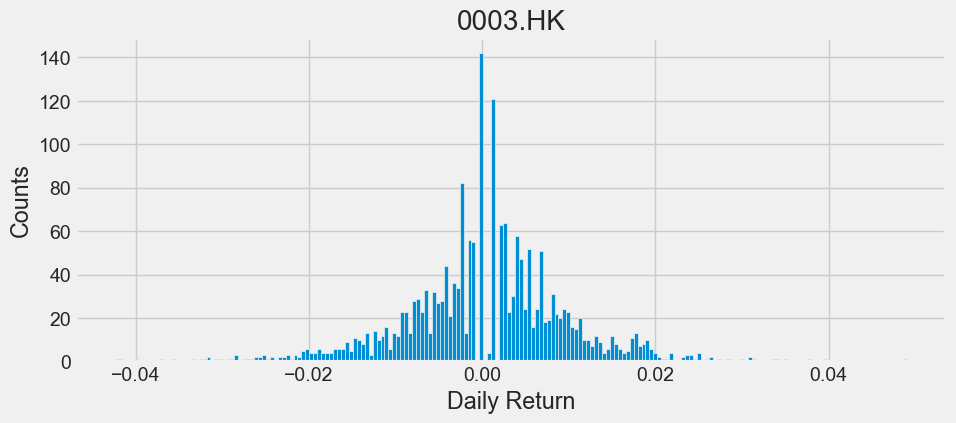

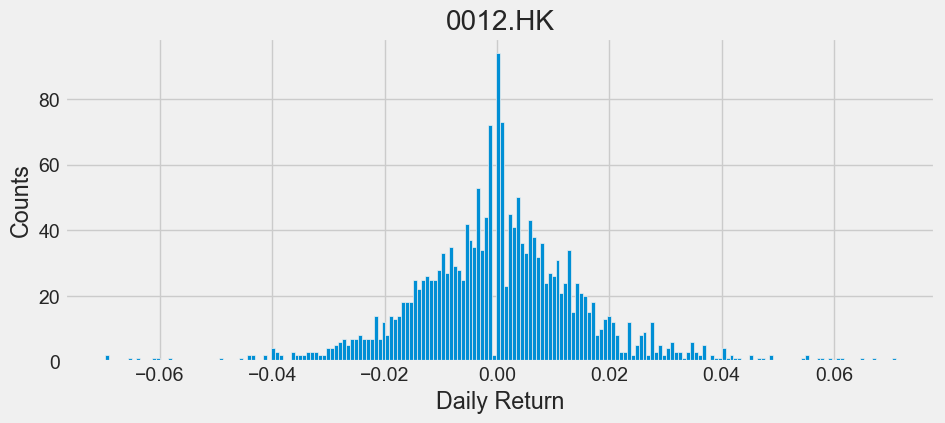

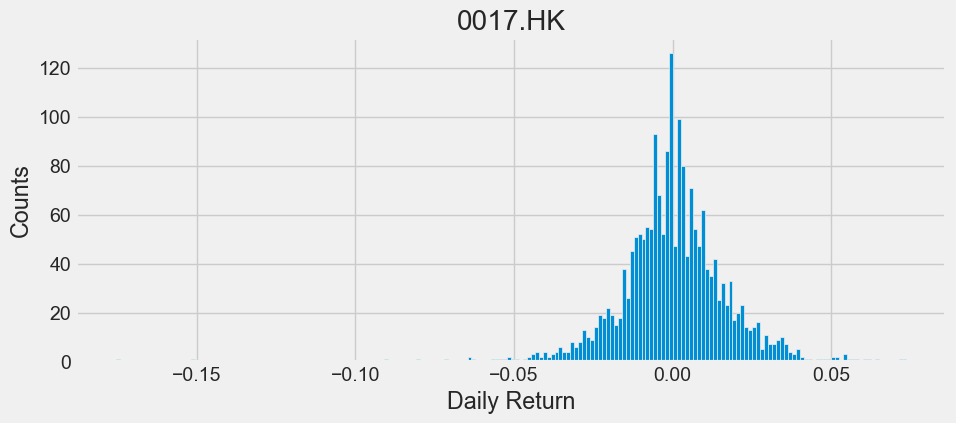

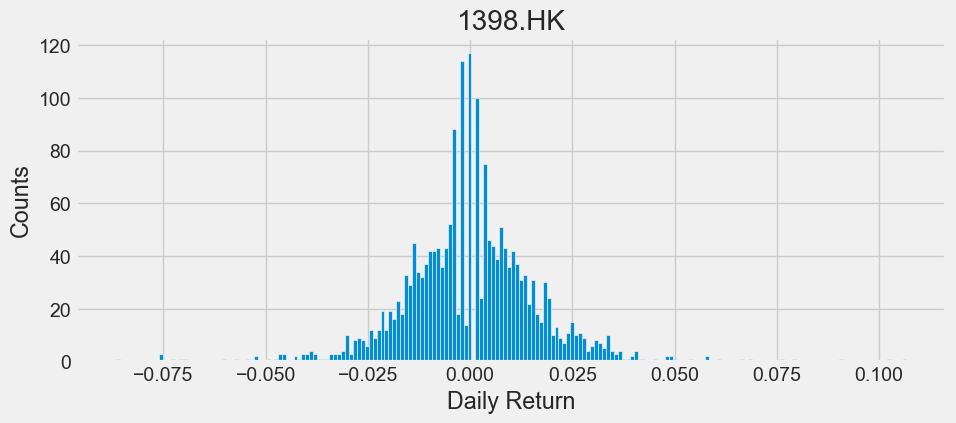

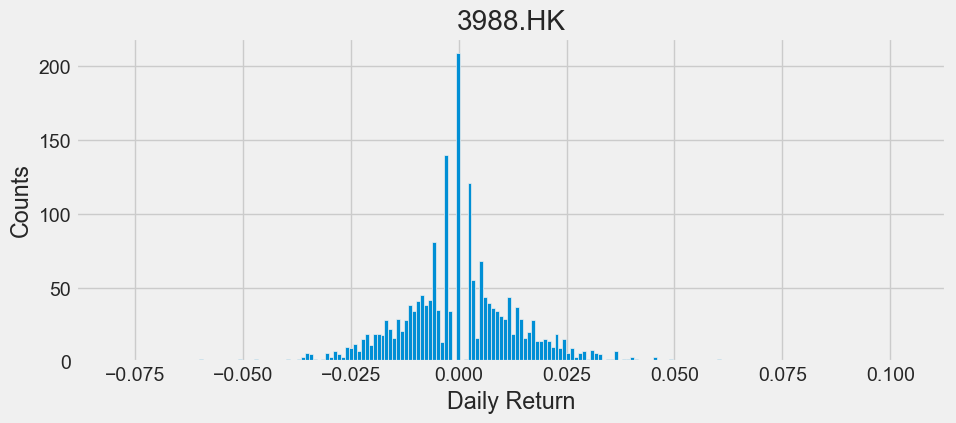

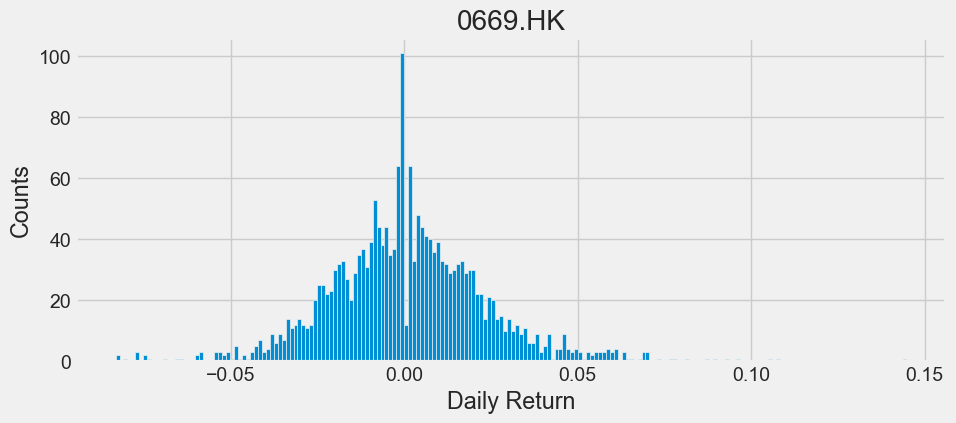

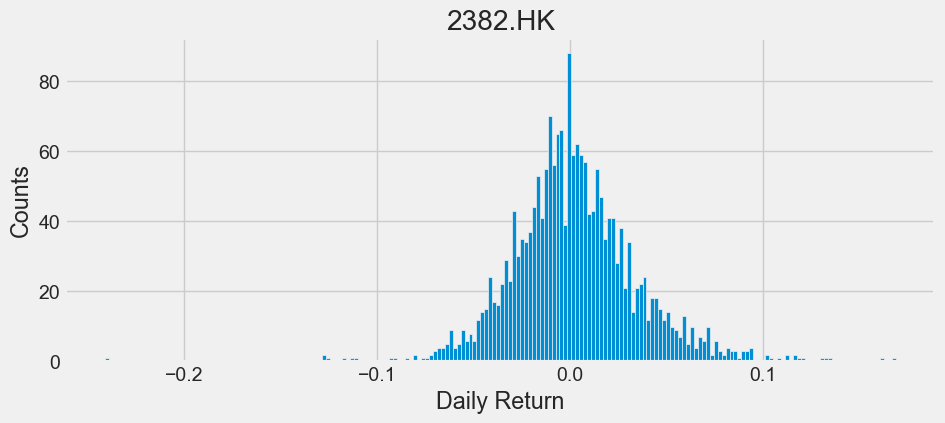

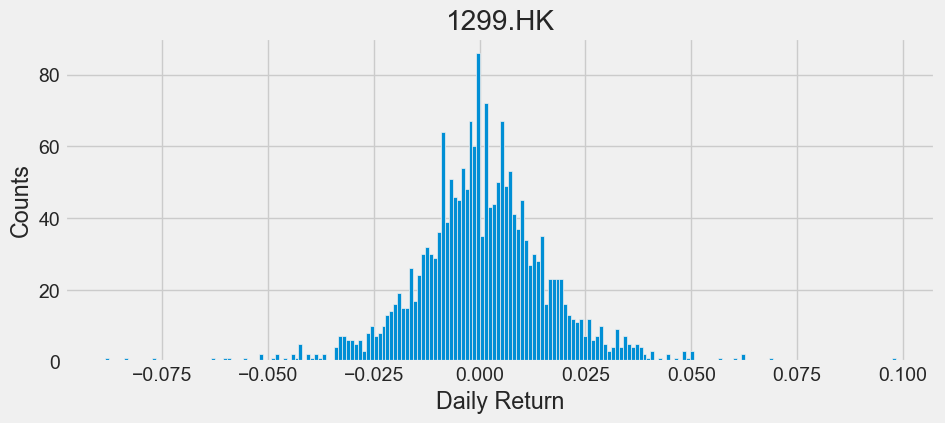

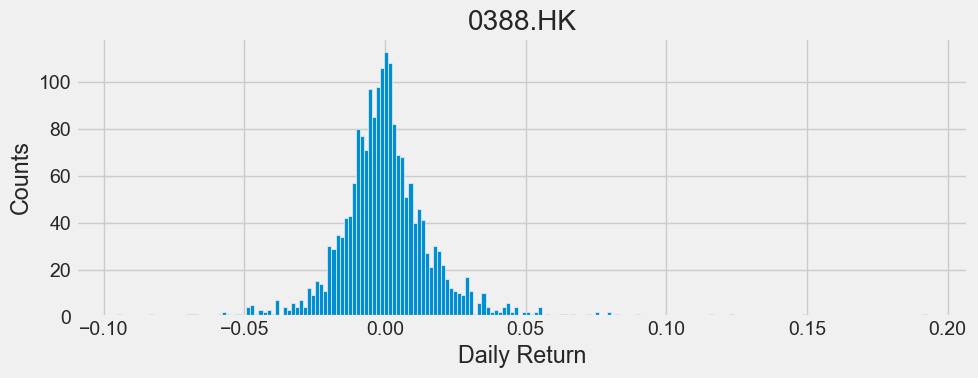

In [5]:
for i, stock in enumerate(tech_list, 1):
    df = dfs[stock]
    plt.figure(figsize=(10, 4))
    df['Daily Return'].hist(bins=200)
    plt.xlabel('Daily Return')
    plt.ylabel('Counts')
    plt.title(f'{tech_list[i - 1]}')
    
plt.tight_layout()

In [6]:
closing_df = pd.DataFrame()

for i, stock in enumerate(tech_list, 1):
    df = dfs[stock]
    closing_df[tech_list[i-1]] = df.Close
    
tech_rets = closing_df.pct_change()

Text(0.5, 1.0, 'Correlation of stock closing price')

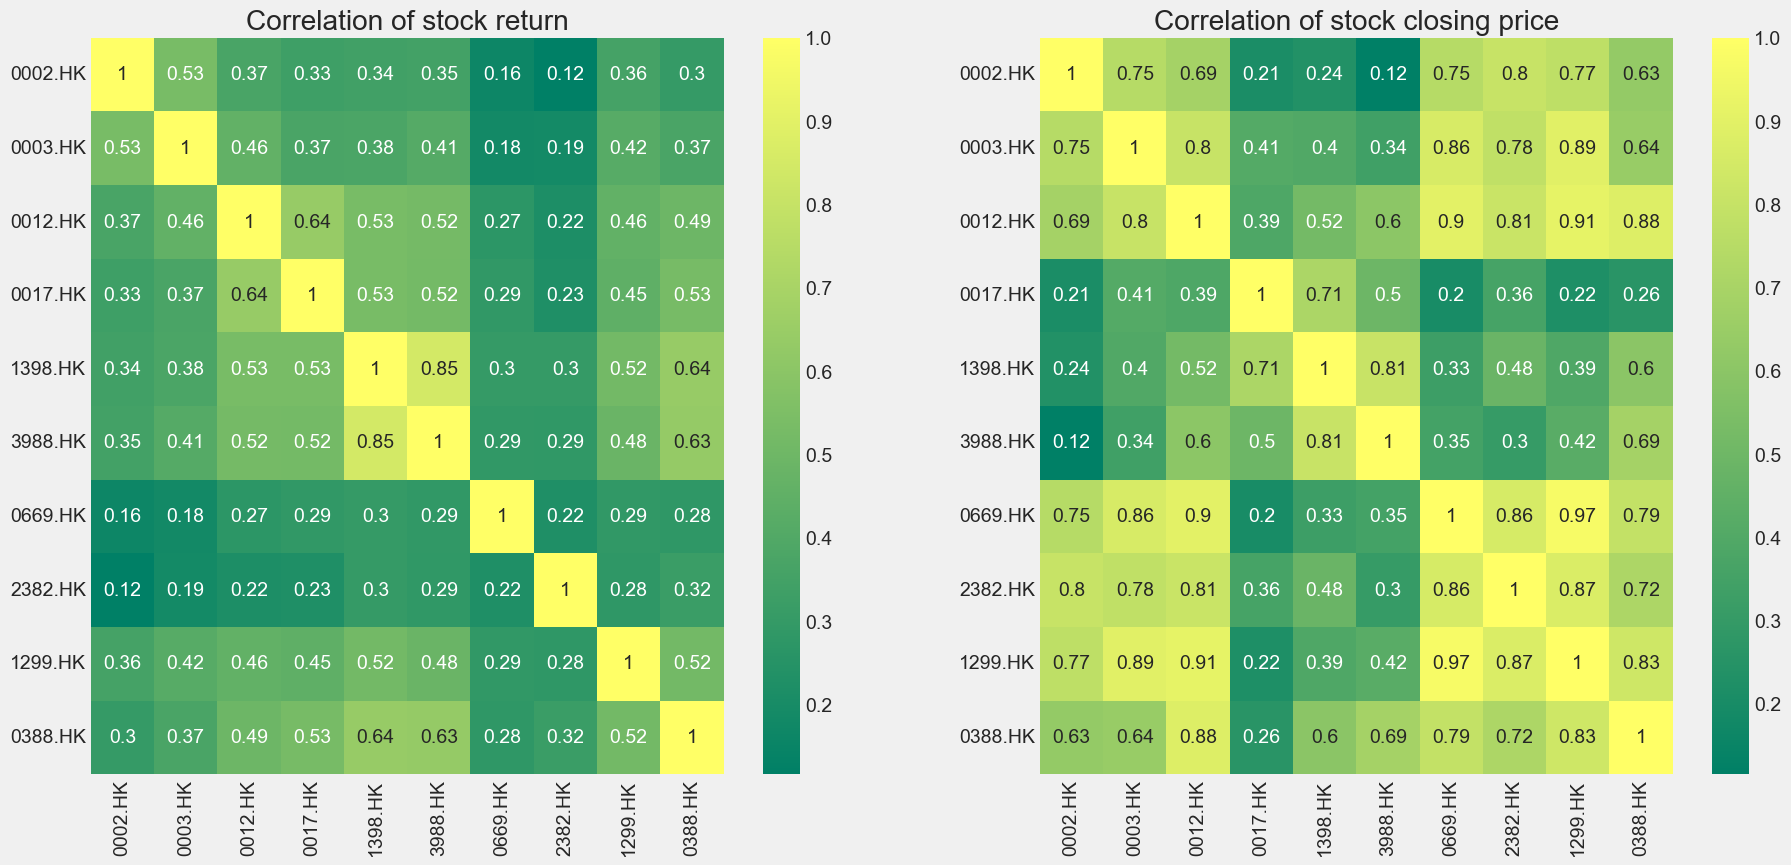

In [7]:
plt.figure(figsize=(20, 20))
plt.subplot(2, 2, 1)
sns.heatmap(tech_rets.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock return')

plt.subplot(2, 2, 2)
sns.heatmap(closing_df.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock closing price')

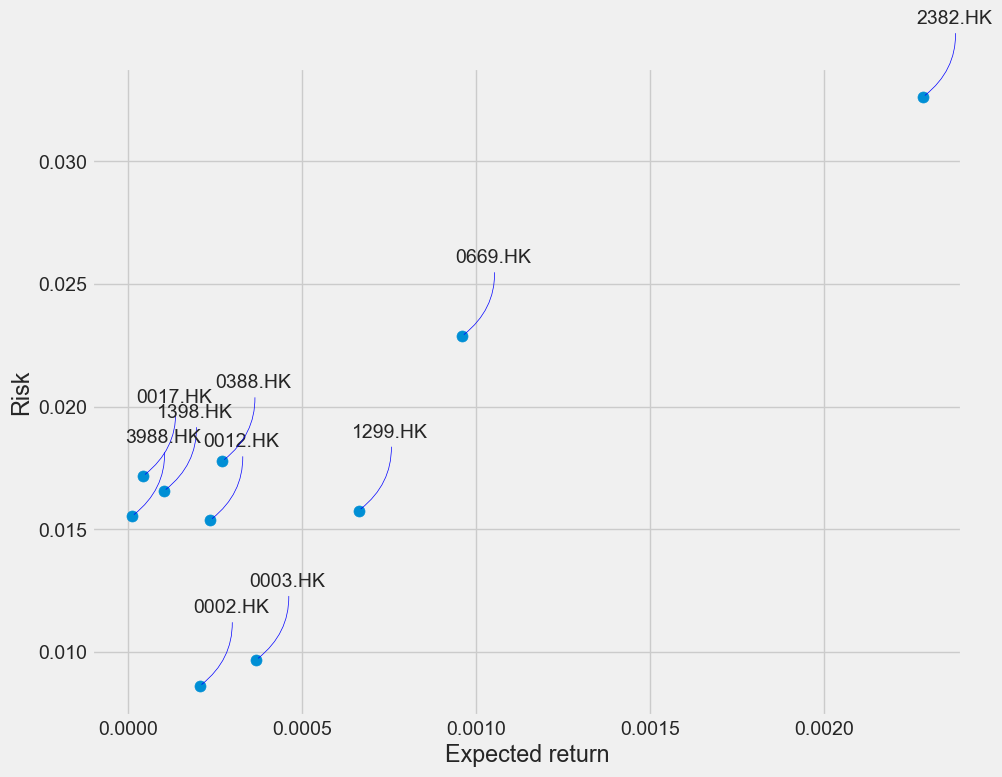

In [8]:
rets = tech_rets.dropna()

area = np.pi * 20

plt.figure(figsize=(10, 8))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')

for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', 
                arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

In [9]:
data = dfs[tech_list[2]].filter(['Close'])
dataset = data.values
training_data_len = int(np.ceil( len(dataset) * .60 ))
print(training_data_len)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

1182


array([[0.37289769],
       [0.3882099 ],
       [0.38460706],
       ...,
       [0.65301232],
       [0.63386426],
       [0.62588576]])

In [10]:
window = 10 #before w to now day
target = 5 #further t day
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(window, len(train_data)-target):
    x_train.append(train_data[i-window:i, 0])
    y_train.append(train_data[i+target, 0])
        
# # Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# # Reshape the data
# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# # x_train.shape
for i in range(5):
    print("x_train:", x_train[i], ", output:", y_train[i])
print("x_train:", x_train.shape, ", output:", y_train.shape)


x_train: [[0.37289769]
 [0.3882099 ]
 [0.38460706]
 [0.41523147]
 [0.41523147]
 [0.40442288]
 [0.4206358 ]
 [0.42243722]
 [0.4062243 ]
 [0.39271351]] , output: 0.3819048587059476
x_train: [[0.3882099 ]
 [0.38460706]
 [0.41523147]
 [0.41523147]
 [0.40442288]
 [0.4206358 ]
 [0.42243722]
 [0.4062243 ]
 [0.39271351]
 [0.39721713]] , output: 0.38100421550033003
x_train: [[0.38460706]
 [0.41523147]
 [0.41523147]
 [0.40442288]
 [0.4206358 ]
 [0.42243722]
 [0.4062243 ]
 [0.39271351]
 [0.39721713]
 [0.39991926]] , output: 0.3801034383800287
x_train: [[0.41523147]
 [0.41523147]
 [0.40442288]
 [0.4206358 ]
 [0.42243722]
 [0.4062243 ]
 [0.39271351]
 [0.39721713]
 [0.39991926]
 [0.40442288]] , output: 0.3765005977281909
x_train: [[0.41523147]
 [0.40442288]
 [0.4206358 ]
 [0.42243722]
 [0.4062243 ]
 [0.39271351]
 [0.39721713]
 [0.39991926]
 [0.40442288]
 [0.3918128 ]] , output: 0.37559982060788966
x_train: (1167, 10, 1) , output: (1167,)


Epoch 1/5
117/117 [==============================] - 3s 3ms/step - loss: 0.0354
Epoch 2/5
117/117 [==============================] - 0s 3ms/step - loss: 0.0148
Epoch 3/5
117/117 [==============================] - 0s 3ms/step - loss: 0.0148
Epoch 4/5
117/117 [==============================] - 0s 3ms/step - loss: 0.0147
Epoch 5/5
117/117 [==============================] - 0s 3ms/step - loss: 0.0145


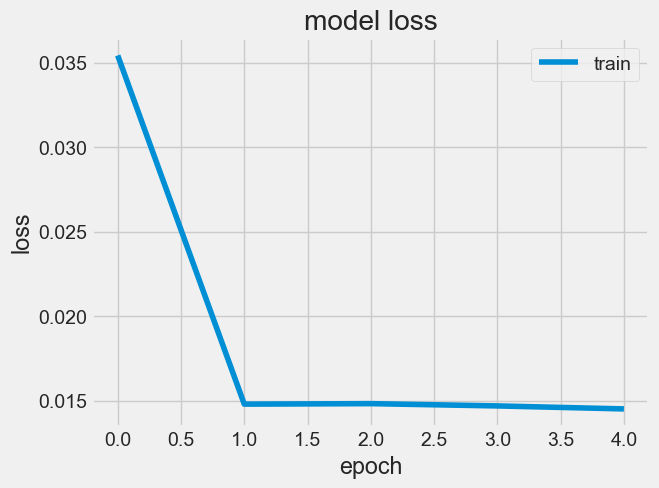

In [20]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(16, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))


# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(x_train, y_train, batch_size=10, epochs=5)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [21]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - window: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len+target:, :]
for i in range(window, len(test_data)-target):
    x_test.append(test_data[i-window:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)


# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

25/25 [==============================] - 0s 1ms/step


0.01335751622479695

In [22]:
# Plot the data
valid = data[training_data_len:-target]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.plot(valid[['Close', 'Predictions']],linewidth=1)
plt.legend([ 'Val', 'Predictions'], loc='lower right')
plt.show()

ValueError: Length of values (782) does not match length of index (783)

In [14]:
data = dfs[tech_list[2]].filter(['Close'])

data['chg'] = data.pct_change()
dataset = data.filter(['chg'])
dataset = dataset.dropna().values
training_data_len = int(np.ceil( len(dataset) * .60 ))

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.60730566],
       [0.47030035],
       [0.71590775],
       ...,
       [0.5414046 ],
       [0.38795602],
       [0.45032482]])

In [15]:
window = 10 #before w to now day
target = 5 #further t day
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(window, len(train_data)-target):
    x_train.append(train_data[i-window:i, 0])
    y_train.append(train_data[i+target, 0])
        
# # Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# # Reshape the data
# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# # x_train.shape
for i in range(1):
    print("x_train:", x_train[i], ", output:", y_train[i])
print("x_train:", x_train.shape, ", output:", y_train.shape)


x_train: [[0.60730566]
 [0.47030035]
 [0.71590775]
 [0.49606957]
 [0.42081025]
 [0.6101683 ]
 [0.50854658]
 [0.38397256]
 [0.40115662]
 [0.52813607]] , output: 0.48958656176024884
x_train: (1167, 10, 1) , output: (1167,)


Epoch 1/5
117/117 [==============================] - 3s 3ms/step - loss: 0.0263
Epoch 2/5
117/117 [==============================] - 0s 3ms/step - loss: 0.0147
Epoch 3/5
117/117 [==============================] - 0s 3ms/step - loss: 0.0150
Epoch 4/5
117/117 [==============================] - 0s 3ms/step - loss: 0.0148
Epoch 5/5
117/117 [==============================] - 0s 3ms/step - loss: 0.0145


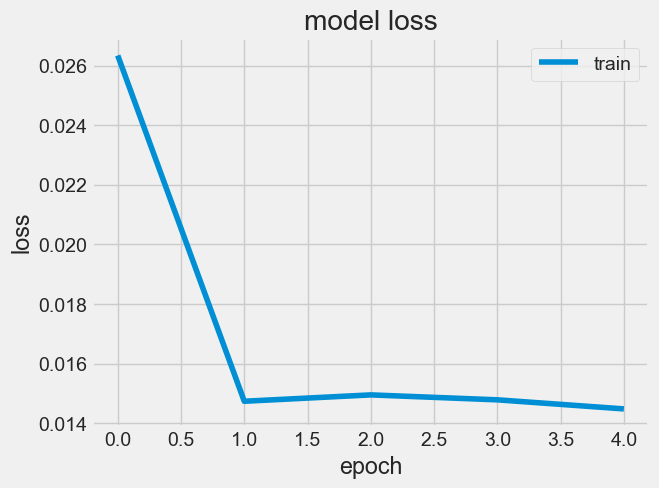

In [16]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(16, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))


# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(x_train, y_train, batch_size=10, epochs=5)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [17]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - window: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len+target:]
for i in range(window, len(test_data)-target):
    x_test.append(test_data[i-window:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)


# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

25/25 [==============================] - 0s 1ms/step


0.013768344961999707

C:\Users\bruce\AppData\Local\Temp\ipykernel_25144\2420434998.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['PredChg']=np.insert(predictions, 0, 0)
C:\Users\bruce\AppData\Local\Temp\ipykernel_25144\2420434998.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["PredClose"] =(1+ valid.PredChg) *valid.shift(1).Close


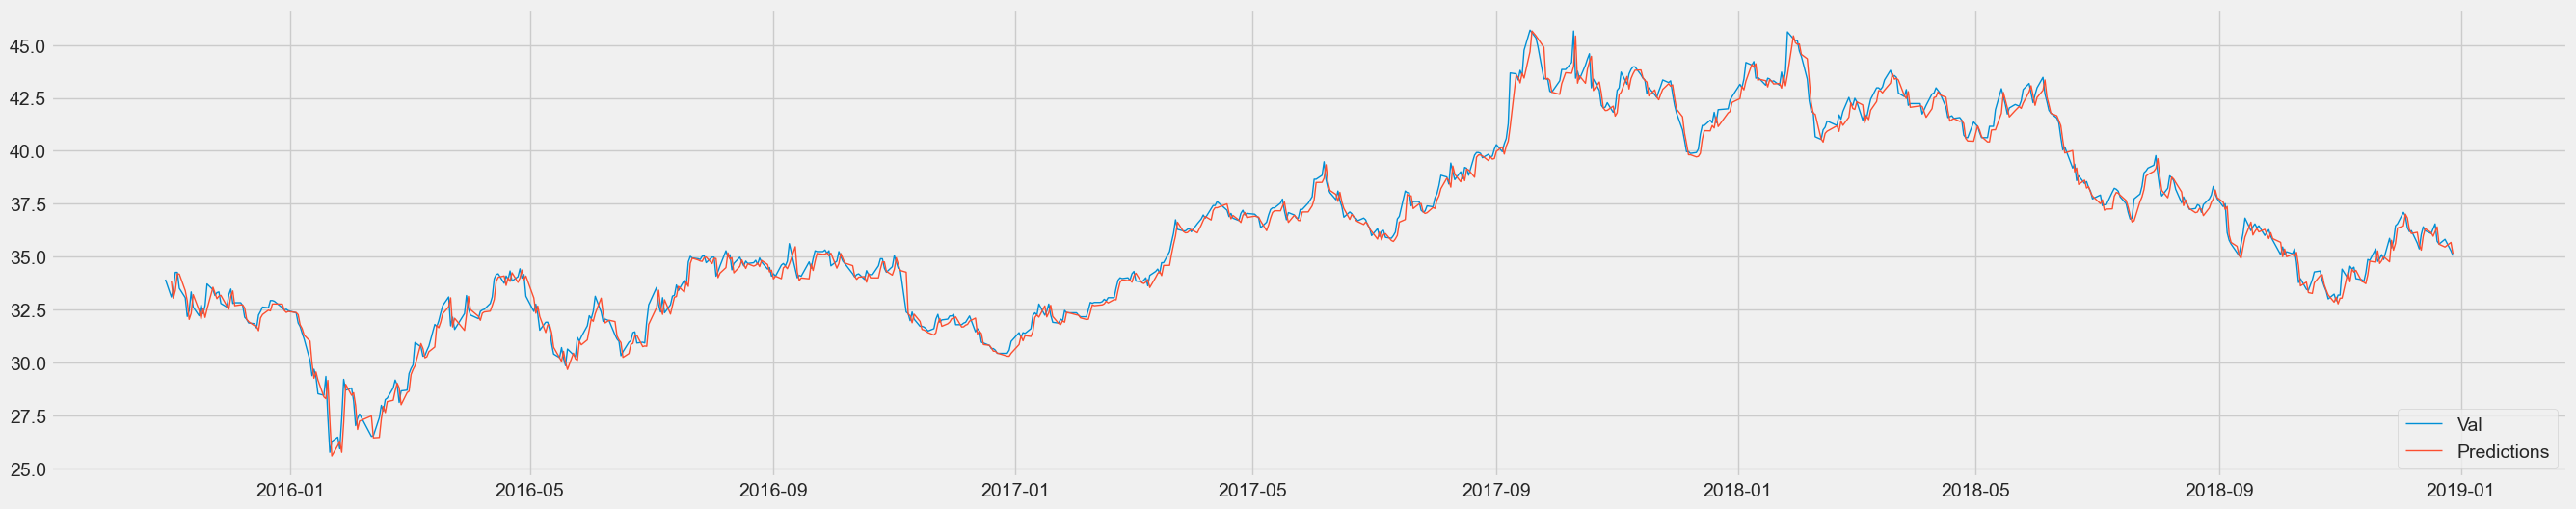

In [18]:
data = dfs[tech_list[2]].filter(['Close'])
data['chg'] = data.pct_change()
valid = data[training_data_len+target:]
valid['PredChg']=np.insert(predictions, 0, 0)
valid["PredClose"] =(1+ valid.PredChg) *valid.shift(1).Close
plt.figure(figsize=(30,6))
plt.plot(valid[['Close', 'PredClose']],linewidth=1)
plt.legend([ 'Val', 'Predictions'], loc='lower right')
plt.show()